In [1]:
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
from matplotlib.mlab import PCA as mlabPCA
from sklearn import linear_model

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

def my_plot_loop(X,y):
    
    list_features = X.columns
    listlength = len(list_features)+1
    f, axes = plt.subplots(listlength, 3, sharey=False, sharex=False , figsize=(20,20))

    i = 1
    for column in list_features:
        plt.subplot(listlength, 3, i)
        sns.scatterplot(X[column],y)

        plt.subplot(listlength, 3, i+1)
        sns.boxplot(X[column] )

        plt.subplot(listlength, 3, i+2)
        #plt.title(column)
        plt.xlabel(column)
        plt.hist(X[column], bins="auto")
        i = i + 3

    #Plot Y Variable
    plt.subplot(listlength, 3, i)
    sns.scatterplot(y,y)

    plt.subplot(listlength, 3, i+1)
    sns.boxplot(y )

    plt.subplot(listlength, 3, i+2)
    #plt.title(column)
    plt.xlabel(y_var)
    plt.hist(y, bins="auto")
    return None
    

        

In [2]:
#test = pd.DataFrame(raw)
#test.columns = ['City','Population','Violent_Crime','Murder','Rape1','Rape2','Robbery','Assault',
#               'Property_Crime','Burglary','Larceny_Theft','Vehicle_Theft','Arson']


#Feature Engineering

#test['Violent_Crime_Sqrt'] = test.Violent_Crime ** (1/2)
#test['Population_Sqrt'] = np.sqrt(test.Population)
#test['LargeCity'] = np.where(test.Population > 25000,1,0)
#test['SmallCity'] = np.where(test.Population < 10000,1,0)

#regr.predict(test.loc[test.City == 'Syracuse',feature_list])**2
#

In [3]:
file = 'table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'

raw = pd.read_excel(file, skiprows=4)


raw2 = pd.DataFrame(raw)
raw2.columns = ['City','Population','Violent_Crime','Murder','Rape1','Rape2','Robbery','Assault',
               'Property_Crime','Burglary','Larceny_Theft','Vehicle_Theft','Arson']


#Data Cleaning
raw2.drop(columns='Rape1', axis=1, inplace=True)
raw2.dropna(subset=['Population'],inplace=True)
raw2['Arson'] = np.where(raw2.Arson.isnull(),0,1)
raw2 = raw2[raw2.Population < 40000]

#Feature Engineering
#raw2['Murder'] = np.where(raw2.Murder > 0, 1, 0)
raw2['Murder_Sqrt'] = np.sqrt(raw2.Murder)
raw2['Violent_Crime_Sqrt'] = raw2.Violent_Crime ** (1/2)
raw2['Population_Square'] = np.square(raw2.Population)
raw2['Population_Sqrt'] = np.sqrt(raw2.Population)
raw2['Robbery_Sqrt'] = np.sqrt(raw2.Robbery)
raw2['Assault_Sqrt'] = np.sqrt(raw2.Assault)
raw2['Burglary_Square'] = np.square(raw2.Burglary)
raw2['Burglary_Sqrt'] = np.sqrt(raw2.Burglary)
raw2['Property_Crime_Sqrt'] = np.sqrt(raw2.Property_Crime)
raw2['Property_Crime_Square'] = np.square(raw2.Property_Crime)
raw2['Property_Crime_Exp'] = 1 / np.exp(raw2.Property_Crime)
raw2['Rape2_Sqrt'] = np.sqrt(raw2.Rape2)
raw2['Larceny_Theft_Square'] = np.square(raw2.Larceny_Theft)
raw2['Larceny_Burglary_Avg_Sqrt'] = np.sqrt((raw2.Larceny_Theft + raw2.Burglary)/2)
raw2['LargeCity'] = np.where(raw2.Population > 25000,1,0)
raw2['SmallCity'] = np.where(raw2.Population < 10000,1,0)
raw2['Robbery_Assault_Avg_Sqrt'] = np.sqrt((raw2.Assault + raw2.Robbery)/2)

#Feature_List
#feature_list = ['Population', 'Larceny_Theft', 'Burglary_Sqrt']

feature_list = ['Population_Sqrt','Violent_Crime_Sqrt', 'LargeCity']
feature_list = ['Population_Sqrt','Rape2_Sqrt','Robbery_Assault_Avg_Sqrt', 'LargeCity']
feature_list = ['Population_Sqrt','Rape2_Sqrt','Robbery_Sqrt', 'Murder_Sqrt']

y_var = 'Property_Crime_Sqrt'

print(raw2[feature_list].shape)
raw2[feature_list].head()


(318, 4)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


,Population_Sqrt,Rape2_Sqrt,Robbery_Sqrt,Murder_Sqrt
0,43.139,0.000,0.000,0.000
1,50.764,0.000,0.000,0.000
2,53.348,0.000,0.000,0.000
4,79.925,1.732,2.000,0.000
5,63.945,0.000,1.732,0.000


In [4]:
#Check for null rows
#raw2[raw2.isnull().any(axis=1)]

#raw2.dropna(inplace=True)
print('----- LISTING NULLS --------')
raw2[raw2.isnull().any(axis=1)]

----- LISTING NULLS --------


,City,Population,Violent_Crime,Murder,Rape2,Robbery,Assault,Property_Crime,Burglary,Larceny_Theft,...,Burglary_Sqrt,Property_Crime_Sqrt,Property_Crime_Square,Property_Crime_Exp,Rape2_Sqrt,Larceny_Theft_Square,Larceny_Burglary_Avg_Sqrt,LargeCity,SmallCity,Robbery_Assault_Avg_Sqrt


                 Population_Sqrt  Rape2_Sqrt  Robbery_Sqrt  Murder_Sqrt
Population_Sqrt            1.000       0.519         0.680        0.343
Rape2_Sqrt                 0.519       1.000         0.694        0.429
Robbery_Sqrt               0.680       0.694         1.000        0.566
Murder_Sqrt                0.343       0.429         0.566        1.000


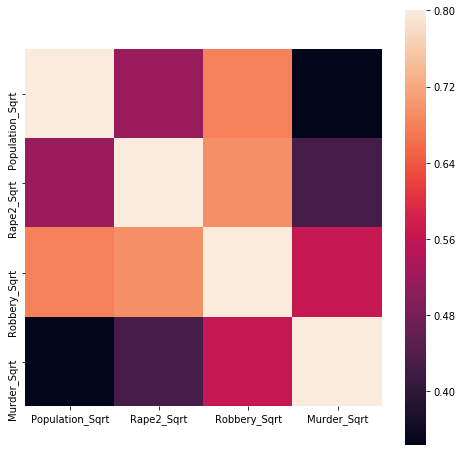

In [5]:
#Feature Selection - Check for multicollinearity
corrmat = raw2[feature_list].corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()


In [6]:
regr = linear_model.LinearRegression()
Y = raw2[y_var]  #.values.reshape(-1, 1)
X = raw2[feature_list]
regr.fit(X, Y)

# Inspect the results.
print('---- Regression Results ----')
print([feature_list])
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

---- Regression Results ----
[['Population_Sqrt', 'Rape2_Sqrt', 'Robbery_Sqrt', 'Murder_Sqrt']]

Coefficients: 
 [ 0.08206118  2.04316782  1.68198615 -1.99992658]

Intercept: 
 1.251918424911823

R-squared:
0.8068695161531654


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


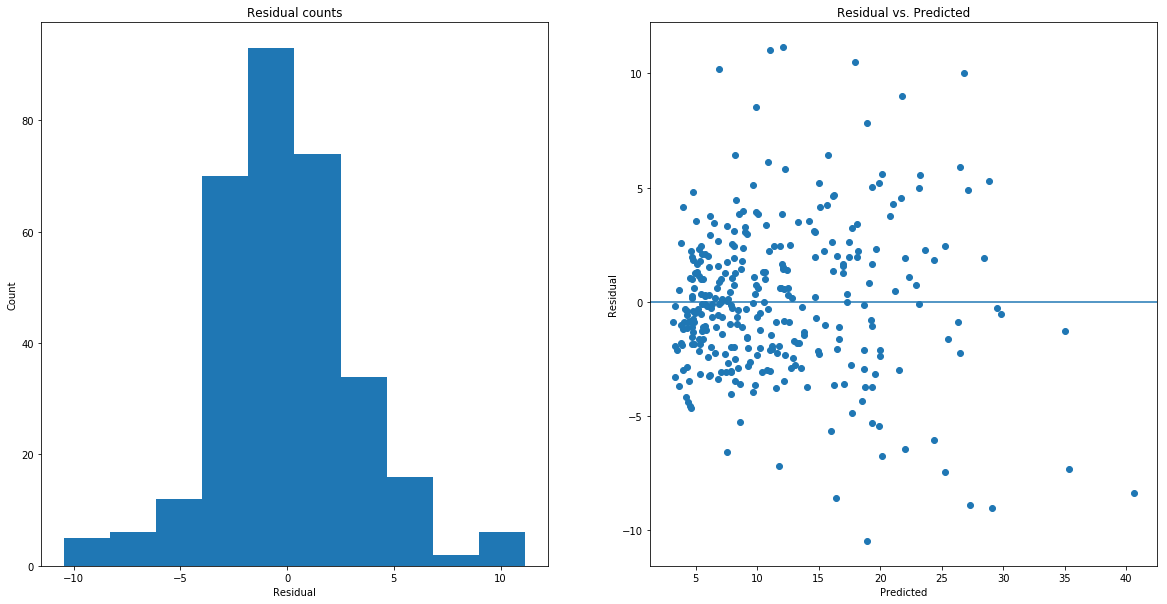

In [7]:
#Check for assumption: multivariate normality
fig = plt.figure(figsize=(20,10))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = raw2[y_var]

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
fig.add_subplot(121)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

fig.add_subplot(122)
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')




plt.show()

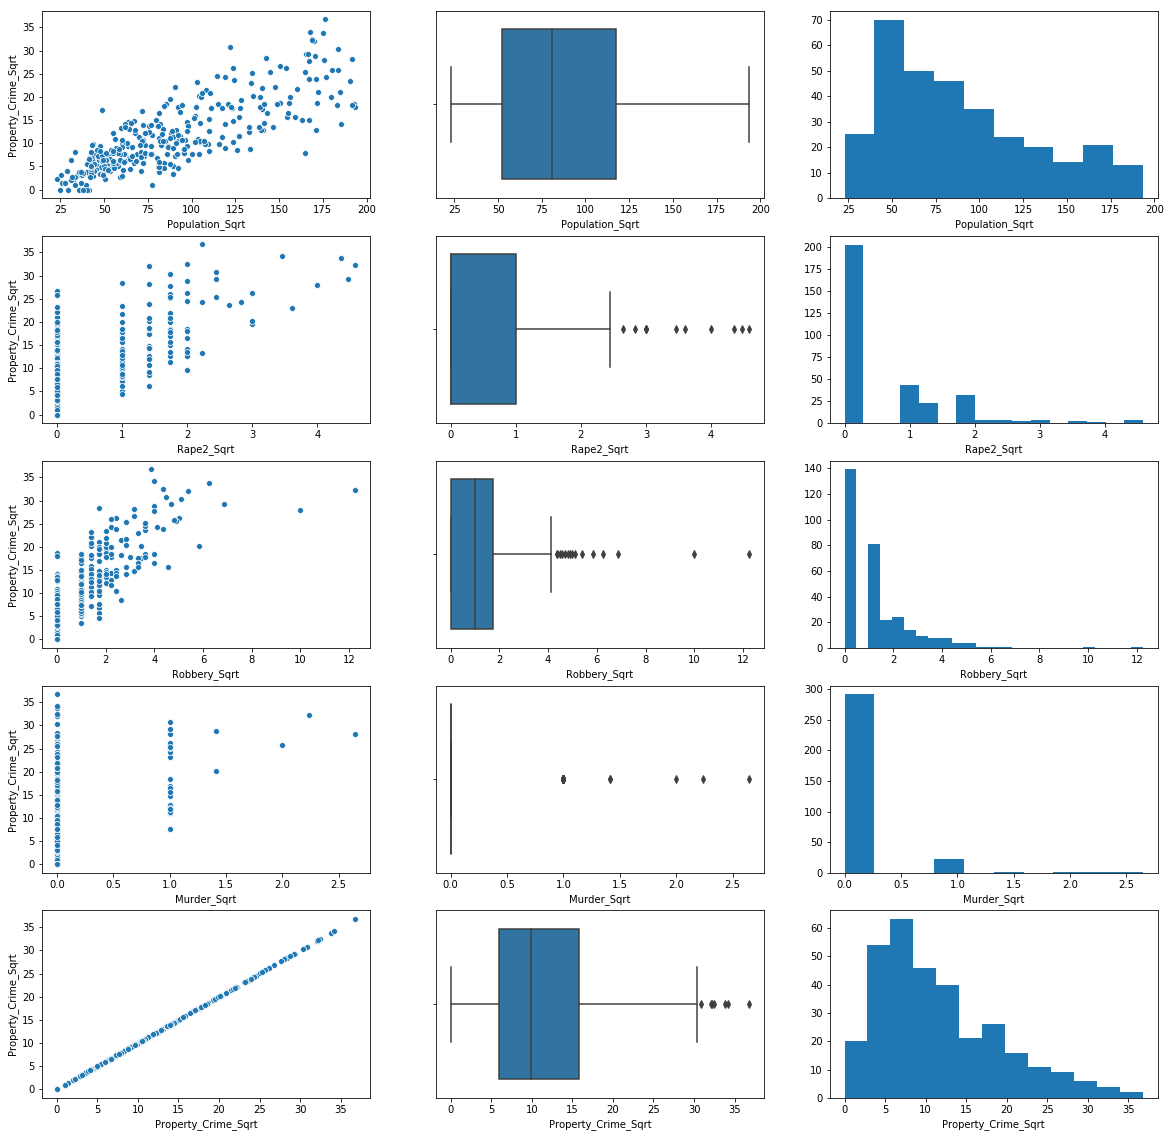

In [8]:
my_plot_loop(raw2[feature_list],raw2[y_var])